In [73]:
import pandas as pd
import numpy as np


In [74]:
data = pd.read_csv('titanic.csv')

In [75]:
data = data[["pclass", "sex", "fare", "embarked","alive"]]

In [76]:
data

,pclass,sex,fare,embarked,alive
0,3,male,7.2500,S,no
1,1,female,71.2833,C,yes
2,3,female,7.9250,S,yes
3,1,female,53.1000,S,yes
4,3,male,8.0500,S,no
...,...,...,...,...,...
886,2,male,13.0000,S,no
887,1,female,30.0000,S,yes
888,3,female,23.4500,S,no
889,1,male,30.0000,C,yes


In [77]:

data["fare"].fillna(data["fare"].mean(), inplace=True)
data["embarked"].fillna(data["embarked"].mode()[0], inplace=True)

C:\Users\Shresth\AppData\Local\Temp\ipykernel_12568\1641952474.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["fare"].fillna(data["fare"].mean(), inplace=True)
C:\Users\Shresth\AppData\Local\Temp\ipykernel_12568\1641952474.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    891 non-null    int64  
 1   sex       891 non-null    object 
 2   fare      891 non-null    float64
 3   embarked  891 non-null    object 
 4   alive     891 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 34.9+ KB


In [79]:
data["sex"] = data["sex"].map({"female": 0, "male": 1})
data["embarked"] = data["embarked"].map({"C": 0, "Q": 1, "S": 2})
data["alive"] = data["alive"].map({"no": 0, "yes": 1})

In [80]:
def standardize_data(x):
    return (x - np.mean(x)) / np.std(x)
data = data.apply(standardize_data)

In [81]:
def calculate_euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))
def calculate_cluster_radius_from_sums(num_points, linear_sum, squared_sum):
   return np.sqrt(-((linear_sum/num_points) ** 2 )+(squared_sum/num_points))  
def calculate_cluster_mean_from_sum(num_points, linear_sum):
    return linear_sum/num_points

In [ ]:
class ClusterNode:
    """
    Represents a node in the CF-Tree. It can be a leaf or an internal node.
    """
    def __init__(self, is_leaf_node=False):
        self.is_leaf_node = is_leaf_node
        self.subclusters = []  # For leaves, entries are CFs. For internal nodes, entries are [CF, child_node].
        self.parent = None
        self.next_leaf = None
        self.prev_leaf = None

    def is_full(self, branching_factor):
      
        return len(self.subclusters) >= branching_factor

class BIRCH:

    def __init__(self, branching_factor=50, threshold=1.5):
        self.branching_factor = branching_factor
        self.threshold = threshold
        self.root = ClusterNode(is_leaf_node=True)
        self.leaf_head = self.root

    def distance(self, point1, point2):
       
        return np.linalg.norm(point1 - point2)

    def init_cluster(self, point):
        return [1, point, point**2]

    def join_dsu(self, cluster_feature1, cluster_feature2):
        num_points1, linear_sum1, squared_sum1 = cluster_feature1
        num_points2, linear_sum2, squared_sum2 = cluster_feature2
        return [num_points1 + num_points2, linear_sum1 + linear_sum2, squared_sum1 + squared_sum2]

    def find_center(self, cluster_feature):
        num_points, linear_sum, _ = cluster_feature
        return linear_sum / num_points

    def find_rad(self, cluster_feature):
        num_points, linear_sum, squared_sum = cluster_feature
        if num_points == 0:
            return 0
        return np.sqrt(np.sum((squared_sum / num_points) - (linear_sum / num_points)**2))

    def closest_child(self, node, point):
        min_dist = float('inf')
        closest_child_node = None
        closest_entry = None
        
        for entry in node.subclusters:
            cluster_feature, child_node = entry
            centroid = self.find_center(cluster_feature)
            distance = self.distance(point, centroid)
            if distance < min_dist:
                min_dist = distance
                closest_child_node = child_node
                closest_entry = entry
        return closest_entry, closest_child_node

    def closest_sibling(self, leaf_node, point):
        min_dist = float('inf')
        closest_entry = None
        for entry in leaf_node.subclusters:
            centroid = self.find_center(entry)
            distance = self.distance(point, centroid)
            if distance < min_dist:
                min_dist = distance
                closest_entry = entry
        return closest_entry

    def _split_full_node(self, node):
        """Split a node (leaf or internal) that is full."""
        parent_node = node.parent
        if parent_node is None:
           
            parent_node = ClusterNode()
            self.root = parent_node
            parent_node.subclusters.append([self._calculate_summary_for_node(node), node])
            node.parent = parent_node

        new_node = ClusterNode(is_leaf_node=node.is_leaf_node)
        new_node.parent = parent_node

       
        farthest_i, farthest_j = -1, -1
        max_dist = -1
        entries_to_consider = node.subclusters
        for i in range(len(entries_to_consider)):
            for j in range(i + 1, len(entries_to_consider)):
                cluster_feature1 = entries_to_consider[i][0] if not node.is_leaf_node else entries_to_consider[i]
                cluster_feature2 = entries_to_consider[j][0] if not node.is_leaf_node else entries_to_consider[j]
                distance = self.distance(self.find_center(cluster_feature1), self.find_center(cluster_feature2))
                if distance > max_dist:
                    max_dist = distance
                    farthest_i, farthest_j = i, j
        
        seed1_entry = entries_to_consider[farthest_i]
        seed2_entry = entries_to_consider[farthest_j]

        # Reset entries and add seeds to the two nodes
        temp_entries = [e for i, e in enumerate(entries_to_consider) if i not in [farthest_i, farthest_j]]
        node.subclusters = [seed1_entry]
        new_node.subclusters = [seed2_entry]

        for entry in temp_entries:
            cluster_feature = entry[0] if not node.is_leaf_node else entry
            dist1 = self.distance(self.find_center(cluster_feature), self.find_center(seed1_entry[0] if not node.is_leaf_node else seed1_entry))
            dist2 = self.distance(self.find_center(cluster_feature), self.find_center(seed2_entry[0] if not node.is_leaf_node else seed2_entry))
            if dist1 <= dist2:
                node.subclusters.append(entry)
            else:
                new_node.subclusters.append(entry)

        # If it was a leaf split, update the doubly linked list of leaves
        if node.is_leaf_node:
            new_node.next_leaf = node.next_leaf
            if node.next_leaf:
                node.next_leaf.prev_leaf = new_node
            node.next_leaf = new_node
            new_node.prev_leaf = node
        else:
           
            for _, child in new_node.subclusters:
                child.parent = new_node

       
        parent_node.subclusters.append([self._calculate_summary_for_node(new_node), new_node])

        for entry in parent_node.subclusters:
            if entry[1] == node:
                entry[0] = self._calculate_summary_for_node(node)
                break
        if parent_node.is_full(self.branching_factor):
            self._split_full_node(parent_node)

    def _calculate_summary_for_node(self, node):
      
        if not node.subclusters:
            return [0, np.array([]), np.array([])]
        
        if node.is_leaf_node:
            
            cluster_features = np.array([cf for cf in node.subclusters], dtype=object)
        else: 
            cluster_features = np.array([entry[0] for entry in node.subclusters], dtype=object)
        
        num_points = np.sum(cluster_features[:, 0])
        linear_sum = np.sum(np.stack(cluster_features[:, 1]), axis=0)
        squared_sum = np.sum(np.stack(cluster_features[:, 2]), axis=0)
        return [num_points, linear_sum, squared_sum]


    def add_data_point(self, point):

        new_cluster_feature = self.init_cluster(point)
        current_node = self.root

        while not current_node.is_leaf_node:
            _, closest_child_node = self.closest_child(current_node, point)
            current_node = closest_child_node

        leaf_node = current_node
        if not leaf_node.subclusters:

            leaf_node.subclusters.append(new_cluster_feature)
            self._update_parent_nodes_summaries(leaf_node, new_cluster_feature)
            return

      
        closest_entry = self.closest_sibling(leaf_node, point)
        
        
        temp_cluster_feature = self.join_dsu(closest_entry, new_cluster_feature)
        if self.find_rad(temp_cluster_feature) <= self.threshold:
           
            closest_entry[:] = temp_cluster_feature
            self._update_parent_nodes_summaries(leaf_node, new_cluster_feature)
        else:

            leaf_node.subclusters.append(new_cluster_feature)
            self._update_parent_nodes_summaries(leaf_node, new_cluster_feature)
           
            if leaf_node.is_full(self.branching_factor):
                self._split_full_node(leaf_node)

    def _update_parent_nodes_summaries(self, node, added_cluster_feature_part):
       
        current = node
        while current.parent:
            parent = current.parent
            for entry in parent.subclusters:
                if entry[1] == current:
                    entry[0] = self.join_dsu(entry[0], added_cluster_feature_part)
                    break
            current = parent

    def train(self, data):

        for i, point in enumerate(data):
            self.add_data_point(point)

    def get_final_cluster_centroids(self):
        centroids = []
        current_leaf = self.leaf_head
        while current_leaf:
            for cluster_feature in current_leaf.subclusters:
                centroids.append(self.find_center(cluster_feature))
            current_leaf = current_leaf.next_leaf
        return np.array(centroids)

    def get_tree_structure(self):
        """Returns a string representation of the BIRCH tree structure."""
        structure = []
        self._build_tree_structure(self.root, 0, structure)
        return "\n".join(structure)

    def _build_tree_structure(self, node, level, structure_list):
        """Recursively builds the tree structure string."""
        indent = "  " * level
        node_type = "Leaf" if node.is_leaf_node else "Internal"
        structure_list.append(f"{indent}{node_type} Node with {len(node.subclusters)} subclusters")
        
        if not node.is_leaf_node:
            for i, (_, child_node) in enumerate(node.subclusters):
                structure_list.append(f"{indent}  -> Child {i+1}:")
                self._build_tree_structure(child_node, level + 1, structure_list)

# Function to assign data points to the closest micro-cluster centroid
    def assign_to_clusters(data_points, centroids):
        labels = []
        for point in data_points:
            distances = [calculate_euclidean_distance(point, centroid) for centroid in centroids]
            closest_centroid_index = np.argmin(distances)
            labels.append(closest_centroid_index)
        return np.array(labels)

# Use the function to get predicted labels from your custom model


In [83]:

numpy_data_array = data.to_numpy()

# Initialize and run BIRCH
birch_model = BIRCH(branching_factor=5, threshold=1.5)
birch_model.train(numpy_data_array)

# Get the centroids of the micro-clusters
final_cluster_centroids = birch_model.get_final_cluster_centroids()
print(f"Found {len(final_cluster_centroids)} micro-clusters.")

# Print a few centroids
print("Example micro-cluster centroids:")
for i in range(min(5, len(final_cluster_centroids))):
    print(final_cluster_centroids[i])

Found 16 micro-clusters.
Example micro-cluster centroids:
[ 0.09603486  0.73769513 -0.26665486 -1.91889341 -0.78927234]
[-0.81700119  0.73769513 -0.09022205  0.57630431 -0.78927234]
[ 0.8020685   0.33927844 -0.3610974   0.44846583 -0.77063552]
[ 0.067541    0.73769513 -0.21221276  0.54582307  1.2669898 ]
[-1.56610693  0.03993891  9.66716653 -1.9423032   1.2669898 ]


In [84]:
# Print the tree structure
tree_str = birch_model.get_tree_structure()
print("--- BIRCH Tree Structure ---")
print(tree_str)

--- BIRCH Tree Structure ---
Internal Node with 2 subclusters
  -> Child 1:
  Internal Node with 4 subclusters
    -> Child 1:
    Leaf Node with 4 subclusters
    -> Child 2:
    Leaf Node with 3 subclusters
    -> Child 3:
    Leaf Node with 3 subclusters
    -> Child 4:
    Leaf Node with 4 subclusters
  -> Child 2:
  Internal Node with 1 subclusters
    -> Child 1:
    Leaf Node with 2 subclusters



--- Scikit-learn BIRCH Evaluation ---
0.10774410774410774 Own Birch Implementation Accuracy
Accuracy: 0.9910213243546577

Confusion Matrix:
[[541   8]
 [  0 342]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       549
           1       0.98      1.00      0.99       342

    accuracy                           0.99       891
   macro avg       0.99      0.99      0.99       891
weighted avg       0.99      0.99      0.99       891



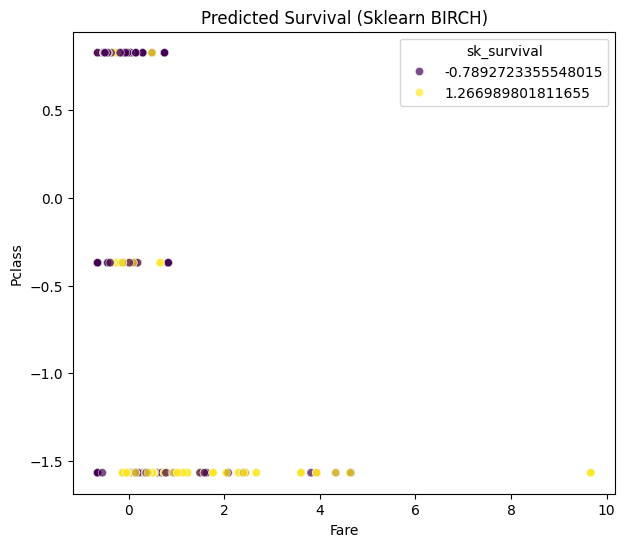

In [72]:
# Compare with scikit-learn's BIRCH
from sklearn.cluster import Birch

print("\n--- Scikit-learn BIRCH Evaluation ---")

# Using same params
sk_birch = Birch(branching_factor=5, threshold=1.5, n_clusters=None)
sk_birch.fit(numpy_data_array)
sk_preds = sk_birch.predict(numpy_data_array)

print(accuracy_score(true_y, sk_preds),"Own Birch Implementation Accuracy")
# Add to dataframe
orig_df['sk_cluster'] = sk_preds

# Map clusters to survival labels
sk_map = {}
for c_id in np.unique(sk_preds):
    mask = (sk_preds == c_id)
    maj_label = orig_df['alive'][mask].mode().iloc[0]
    sk_map[c_id] = maj_label

orig_df['sk_survival'] = orig_df['sk_cluster'].map(sk_map)

sk_pred_y = orig_df['sk_survival'].apply(lambda x: 1 if x > 0 else 0)
true_y = orig_df['alive'].apply(lambda x: 1 if x > 0 else 0)

print(f"Accuracy: {accuracy_score(true_y, sk_pred_y)}")
print("\nConfusion Matrix:")
print(confusion_matrix(true_y, sk_pred_y))
print("\nClassification Report:")
print(classification_report(true_y, sk_pred_y))

# Visualize sklearn results
plt.figure(figsize=(7, 6))
sns.scatterplot(data=orig_df, x='fare', y='pclass', hue='sk_survival', palette='viridis', alpha=0.7)
plt.title('Predicted Survival (Sklearn BIRCH)')
plt.xlabel('Fare')
plt.ylabel('Pclass')
plt.show()